# Env 

In [1]:
cd ..

/Users/svo6059/PycharmProjects/CISS_Project


## Imports 

In [24]:
from project.preprocessing.generator import glove_generator

In [2]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin

In [3]:
import json
import pandas as pd
from sklearn.decomposition import PCA

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas
%load_ext autoreload
%autoreload 2

In [35]:
from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

embedder = GloVeEmbedder(load_path="data/models/glove.txt", 
                         pad_zero=False  # means whether to pad up to the longest sample in a batch
                    )

2019-06-25 21:23:31.515 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 52: [loading GloVe embeddings from `/Users/svo6059/PycharmProjects/CISS_Project/data/models/glove.txt`]
/usr/local/anaconda3/envs/pavlov/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## Functions 

### Generator 

In [8]:
import tensorflow as tf

### Sklearn 

In [156]:
class GloVeWord(TransformerMixin):
    def __init__(self, max_size=None):
        if max_size is None:
            self.fit_size = True
            self.max_size = None
        else:
            self.fit_size = True
            self.max_size = max_size
            self.max_size = max([len(x for x in X)])
            
    def fit(self, X, y):
        if type(X[0]) is not str:
            
        if self.fit_size:
            
        
    def transform(self):
        

class AverageSentence(TransformerMixin):
    """
    Applies glove embeddings
    
    Parameters
    ----------
    method : string
        possible methods are 'concat' and 'average'
    """
    def __init__(self, embedding, method='concat'):
        self.method = method
        
    def fit(self, X, y=None):
        assert type(X[0]) is not str
        self.max_size = max([len(x for x in X)])
        return self
    def transform(self, X, y=None):
        assert type(X[0]) is not str
        emb = embedder(X)
        if self.method == 'concat':
            return emb.reshape(X.shape[0], -1)
        elif self.method == 'average':
            return emb.mean(axis=1)
        else:
            raise NotImplementedError
            
class ConditionalEmbedding(TransformerMixin):
    """
    
    """

## Data loading

In [11]:
train = pd.read_json('data/train.json')
dev = pd.read_json('data/dev.json')

In [12]:
print(train.shape)
print(dev.shape)

(457135, 5)
(54876, 5)


In [ ]:
train_sent_glove = embedder(train.sentence.str.split().apply(lambda l: l[:50]))
train_question_glove = embedder(train.question.str.split().apply(lambda l: l[:30])))
print('train_sent shape:', train_sent_glove.shape)
print('train_question shape:', train_question_glove.shape)

dev_sent_glove = embedder(dev.sentence.str.split())
dev_question_glove = embedder(dev.question.str.split())
print('dev_sent shape:', dev_sent_glove.shape)
print('dev_question shape:', dev_question_glove.shape)

# Body

In [15]:
from nltk import word_tokenize

In [ ]:
word_tokenize()

## Tokenize

In [ ]:
%%time
train['sentence'] = train.sentence.apply(word_tokenize)
train['question'] = train.question.apply(word_tokenize)

In [69]:
%time
dev['sentence'] = dev.sentence.apply(word_tokenize)
dev['question'] = dev.question.apply(word_tokenize)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 8.82 µs


(0, 70)

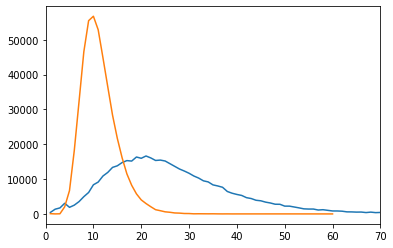

In [22]:
train.sentence.apply(len).value_counts().sort_index().plot()
train.question.apply(len).value_counts().sort_index().plot()
plt.xlim(0,70)

## Test generator

In [85]:
from sklearn.metrics import precision_score

In [ ]:
from keras_metrics import binary_f1_score, binary_precision

In [36]:
s = embedder(train.head(6).sentence)

### Shallow model

In [96]:
inp = tf.keras.layers.Input((200,))
x = tf.keras.layers.Dense(50, activation='relu')(inp)
out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [97]:
BATCH_SIZE = 64
epoch_steps = train.shape[0]//BATCH_SIZE
val_steps = dev.shape[0]//BATCH_SIZE
gen = glove_generator(train, BATCH_SIZE, embedder=embedder)

history = model.fit_generator(gen, steps_per_epoch=epoch_steps, epochs=10, 
                   validation_data = glove_generator(dev, BATCH_SIZE, embedder=embedder), 
                              validation_steps = val_steps)

Epoch 1/10
7142/7142 [==============================] - 70s 10ms/step - loss: 0.4536 - acc: 0.8084 - val_loss: 0.4650 - val_acc: 0.7918
Epoch 2/10
7142/7142 [==============================] - 77s 11ms/step - loss: 0.4190 - acc: 0.8141 - val_loss: 0.4347 - val_acc: 0.8057
Epoch 3/10
7142/7142 [==============================] - 78s 11ms/step - loss: 0.4055 - acc: 0.8200 - val_loss: 0.4294 - val_acc: 0.8089
Epoch 4/10
7142/7142 [==============================] - 77s 11ms/step - loss: 0.3975 - acc: 0.8240 - val_loss: 0.4256 - val_acc: 0.8110
Epoch 5/10
7142/7142 [==============================] - 77s 11ms/step - loss: 0.3931 - acc: 0.8269 - val_loss: 0.4236 - val_acc: 0.8131
Epoch 6/10
7142/7142 [==============================] - 76s 11ms/step - loss: 0.3894 - acc: 0.8286 - val_loss: 0.4200 - val_acc: 0.8151
Epoch 7/10
7142/7142 [==============================] - 76s 11ms/step - loss: 0.3865 - acc: 0.8300 - val_loss: 0.4158 - val_acc: 0.8185
Epoch 8/10
7142/7142 [==========================

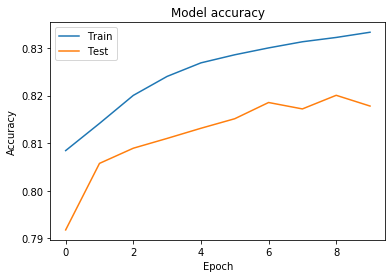

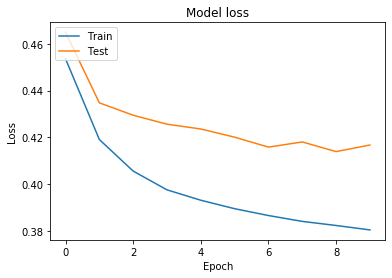

In [100]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Predict if is correct 

In [177]:
question = embedder(data.question.str.split().values[:1000])
%time possible_answer = embedder(data.sentence.str.split().values[:10000])

CPU times: user 3.07 s, sys: 491 ms, total: 3.56 s
Wall time: 3.7 s


In [147]:
%time sent_sizes = data.sentence.str.split().apply(len).value_counts().sort_index()

CPU times: user 3.56 s, sys: 324 ms, total: 3.88 s
Wall time: 3.88 s


In [ ]:
sent = data.sentence.str.split()

In [181]:
import pickle

In [ ]:
pickle.dump

In [180]:
possible_answer.nbytes/(2**30)

0.37997961044311523

In [170]:
pd.DataFrame(sent).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457135 entries, 0 to 457134
Data columns (total 1 columns):
sentence    457135 non-null object
dtypes: object(1)
memory usage: 3.5+ MB


In [129]:
from sklearn.model_selection import cross_validate

## Embedding visualization 

In [62]:
X = data.sentence[:10000].values

In [59]:
proj = make_pipeline(GloVe(), PCA(10), TSNE())

In [76]:
%time xp = GloVeSentence().fit(X).transform(X)

CPU times: user 4.2 s, sys: 745 ms, total: 4.95 s
Wall time: 4.96 s


In [77]:
%time xp = PCA(10).fit(xp).transform(xp)

CPU times: user 35.8 s, sys: 5.53 s, total: 41.3 s
Wall time: 15.5 s


In [80]:
tsne = TSNE()
%time tsne.fit(xp)

CPU times: user 2min 48s, sys: 17 s, total: 3min 5s
Wall time: 3min 5s


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

In [108]:
data[data.sentence.str.contains('At the end of the main drive ')]

,label,question,sentence
6,0,To whom did the Virgin Mary allegedly appear i...,At the end of the main drive (and in a direct ...
13,0,What is in front of the Notre Dame Main Building?,At the end of the main drive (and in a direct ...
20,0,The Basilica of the Sacred heart at Notre Dame...,At the end of the main drive (and in a direct ...
27,0,What is the Grotto at Notre Dame?,At the end of the main drive (and in a direct ...
34,0,What sits on top of the Main Building at Notre...,At the end of the main drive (and in a direct ...


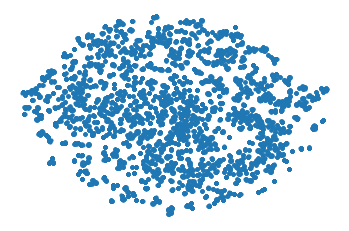

In [103]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], s=10)
ax.set_axis_off()

In [122]:
first_doc = data[data.doc_number==0]